# "ML Instant House Valuation: Part 4 - Model selection and implementation"
> "I will test and train various machine learning models on the prepared dataset. The best model will be exported and used in the web-app development."
- toc:true
- branch: master
- badges: true
- author: Uzair Patel
- categories: [house-prices]

In [1]:
# collapse
import os, json
import warnings
from joblib import load, dump
from tqdm import tqdm

import numpy as np
import pandas as pd

from typing import Callable, Union
from numpy import ndarray

# ml algos dependencies
from cuml import (
    NearestNeighbors, # knn implementation dependency
    RandomForestRegressor,
    ForestInference # gpu accelerated front-end for xgboost, random forest etc.
)
import xgboost as xgb
import treelite # model compiler
# hyperparameter optimisation
from hyperopt import hp, fmin, tpe, Trials 

# visualisation
from pprint import pformat
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.dpi"] = 64
sns.set_theme(style="whitegrid")

In [2]:
# hide
SEED = 10 # for reproducibility
results = {}

os.makedirs("models", exist_ok=True)

SERVER_DIR = "../app/model/data"
os.makedirs(SERVER_DIR, exist_ok=True)

DATASET_PATH = "data/dataset.parquet"

###  Final Preprocessing

In [3]:
df = pd.read_parquet(DATASET_PATH)
df.head()

,PRICE,PRICE_ADJ,YEAR,LAT,LNG,TOTAL_FLOOR_AREA,NUMBER_HABITABLE_ROOMS,PROPERTY_TYPE
DATE_OF_TRANSFER,,,,,,,,
1995-01-01,16000.0,605.142016,1995,53.723903,-1.882344,99.00,4.0,1
1995-01-02,35000.0,1323.748160,1995,52.245071,-0.878169,85.00,4.0,1
1995-01-03,15000.0,567.320640,1995,54.961605,-1.419408,74.00,4.0,4
1995-01-03,48000.0,1815.426048,1995,52.034265,-2.432491,78.00,3.0,6
1995-01-03,82000.0,3101.352831,1995,50.092749,-5.265793,118.88,4.0,6


#####  Scaling data
In order to use distance-based algorithms, which use distance between data points to determine similarity, I will have to scale the data to a closer range. Tree-based algorithms are fairly insensitive to the scaling of data since it only splits a node based on a single feature. Additionally, scaling the data will make results and models more interpretable, as you will more clearly be able to explain the strength of a particular feature determined by the value of its coefficient for the target variable.

I will use **standardisation** (Z-score normalisation) in order to rescale the dataset, calculated by the formula:
$$x' = \frac{x-\mu}{\sigma}$$
Where,  
$\mu$: mean of the dataset  
$\sigma$: standard deviation of the dataset

The standardised data will have zero mean and unit variance, therefore it will allow comparison between different features, which would usually have different unit scales. **It is important I compute the mean and standard deviation using only the train set**, as using the entire dataset could cause unintentional data leakage to the prediction model, i.e it could unintentionally provide information about unobserved data.

Another method I may try is **normalisation** or **min-max scaling** which rescales data to a given range. It is calculated with the formula:
$$x' = a + \frac{(x-min(x))(b-a)}{max(x)-min(x)}$$
Where,  
$[a,b]$: interval in which the dataset will be scaled

Again, the **min and max values should be computed using only the train set** to prevent any unintentional data leakage to the prediction model.

I will create a class which will allow using both scaling methods, and I will attempt to implement an indexing method to return the scaler at a particular column. This will make it easier to inverse scaling on a prediction later on by instantiating a new scaler at the target's column index.

In [4]:
class Scaler:
    def __init__(self):
        pass
    # ============ Fitting ============
    def fit(self, x):
        self._fit = np.array(x) # Fitting an array type for scaling
        return self
    def fit_transform(self, x, method="standardise", **kwargs):
        return self.fit(x), self.scale(x, method, **kwargs)
    # ============ Standardisation ============
    def standardise(self, x):
        self._mean = self._fit.mean(axis=0)
        self._std  = self._fit.std(axis=0)
        return (np.array(x) - self._mean)/self._std
    def inv_standardise(self,x):
        return np.array(x) * self._std + self._mean
    # ============ Normalisation/Min-Max scaling ============
    def min_max(self, x, feature_range=(0,1)):
        assert len(feature_range) == 2, f"Provide only 2 values for feature_range instead of {len(feature_range)} values"
        self._a, self._b = feature_range
        self._min = self._fit.min(axis=0)
        self._max = self._fit.max(axis=0)
        return ((np.array(x)-self._min)*(self._b-self._a))/(self._max-self._min) + self._a
    def inv_min_max(self,x):
        return ((np.array(x)-self._a)*(self._max-self._min))/(self._b-self._a) + self._min
    # ============ General scaling ============
    def scale(self, x, method:str="standardise", **kwargs):
        scale_method = {
            "standardise":self.standardise,
            "zscore":self.standardise,
            "min_max":self.min_max,
            "normalise":self.min_max,
        }[method]
        return scale_method(x)
    def inv(self, x, method="standardise",**kwargs):
        inv_method = {
            "standardise":self.inv_standardise,
            "zscore":self.inv_standardise,
            "min_max":self.inv_min_max,
            "normalise":self.inv_min_max,
        }[method]
        return inv_method(x)
    # ============ Serializing scaler ============
    def serialize(self, names):
        serialized = {}
        if self._fit.ndim == 2:
            for i,name in enumerate(names):
                if hasattr(self, "_mean"):
                    serialized[name] = {
                        "mean": self._mean[i],
                        "std":  self._std[i]
                    }
                if hasattr(self, "_min"):
                    serialized[name] = {
                        "min": self._min[i],
                        "max": self._max[i]
                    }
        else:
            if hasattr(self, "_mean"):
                serialized[names] = {
                    "mean": self._mean,
                    "std":  self._std
                }
            if hasattr(self, "_min"):
                serialized[names] = {
                    "min": self._min,
                    "max": self._max
                } 
        if hasattr(self,"_a"):
            serialized["minmax_range"] = [self._a, self._b]
        return serialized

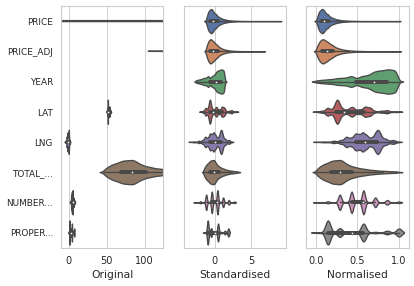

In [5]:
# !hidden
sample = df.sample(n=100_000)
sample_std = Scaler().fit_transform(sample, method="standardise")[1]
sample_norm = Scaler().fit_transform(sample, method="normalise")[1]
f, axs = plt.subplots(1,3,sharey=True)
sns.violinplot(data=sample.values, scale="width", orient="h", ax=axs[0]).set_xlabel("Original")
sns.violinplot(data=sample_std, scale="width", orient="h", ax=axs[1]).set_xlabel("Standardised")
sns.violinplot(data=sample_norm, scale="width", orient="h", ax=axs[2]).set_xlabel("Normalised")
axs[0].set_xlim(-10, 125)
axs[0].set_yticklabels([col[:6]+"..." if len(col) > 9 else col for col in sample.columns])
axs[0].tick_params("y", labelsize="small")

#####  Preprocessed data

In [6]:
from requests import get
from bs4 import BeautifulSoup
def getLatestIndex():
    response = get("https://landregistry.data.gov.uk/app/ukhpi")
    soup = BeautifulSoup(response.content)
    return float(soup.find(class_="c-headline-figure__house-price-index").text.strip()[:-1])
LATEST_INDEX = getLatestIndex()
LATEST_INDEX

145.15

In [7]:
def split(df, tr_pct=0.9, cb_pct=.05):
    tr_spl = int(len(df)*tr_pct)
    cb_spl = tr_spl + int(len(df)*cb_pct)
    return df[:tr_spl], df[tr_spl:cb_spl], df[cb_spl:]

In [8]:
X, y, y2 = df.drop(columns=["PRICE", "PRICE_ADJ"]), df.PRICE, df.PRICE_ADJ

np.random.seed(SEED)
tr_idx, cal_idx, val_idx = split(np.random.permutation(len(df))) # indices for shuffled dataset

# fitting scalers on training data
X_scaler, tr_X = Scaler().fit_transform(X.iloc[tr_idx])
y_scaler, tr_y = Scaler().fit_transform(y.iloc[tr_idx])
y2_scaler, tr_y2 = Scaler().fit_transform(y2.iloc[tr_idx])

# scaling and splitting validation/calibration data
cal_X, val_X = X_scaler.scale(X.iloc[cal_idx]), X_scaler.scale(X.iloc[val_idx])
cal_y, val_y = y_scaler.scale(y.iloc[cal_idx]), y_scaler.scale(y.iloc[val_idx])
cal_y2, val_y2 = y2_scaler.scale(y2.iloc[cal_idx]), y2_scaler.scale(y2.iloc[val_idx])

inv_y = y.values[val_idx]
inv_y2 = y2.values[val_idx] * LATEST_INDEX

In [9]:
# serializing scaling properties for server use
SCALING_PATH = os.path.join(SERVER_DIR, "scaling.json")
json.dump({
    **y_scaler.serialize("price"),
    **y2_scaler.serialize("price_adj"),
    **X_scaler.serialize(X.columns.str.lower())
}, open(SCALING_PATH,"w"), indent=2)

In [10]:
# @hidden
disp = [
    ["full dataset", f"{len(X):,} rows", "-"],
    ["training set", f"{len(tr_idx):,} rows", f"{len(tr_idx)/len(X):.2%}"],
    ["calibration set", f"{len(cal_idx):,} rows", f"{len(cal_idx)/len(X):.2%}"],
    ["validation set", f"{len(val_idx):,} rows", f"{len(val_idx)/len(X):.2%}"]
]
for a in disp:
    for b in a:
        print(b.ljust(20), end="")
    print()

full dataset        4,903,637 rows      -                   
training set        4,413,273 rows      90.00%              
calibration set     245,181 rows        5.00%               
validation set      245,183 rows        5.00%               


###  Model selection

#### Model evaluation and helper functions

* **Mean Absolute Error**. Lower is better.
$$\textit{MAE}=\frac {1}{n}\sum_{i=1}^{n}\left|y_i-\hat{y}_i\right|$$
* **Mean Absolute Percentage Error**. Lower is better.
$$\textit{MAPE}=\frac {100}{n}\sum_{i=1}^{n}\left|\frac {y_i-\hat{y}_i}{y_i}\right|$$
* **Root Mean Squared Error** - error is in the same unit as the dependent variable. MSE & RMSE are useful for checking the effect of outliers on the predictions. Lower is better.
$$\textit{RMSE} = \sqrt{\textit{mean of squares of residuals}} = \sqrt{\frac {1}{n}\sum _{i=1}^n(y_i-{\hat{y}_i})^2}$$
* **R² score** - measures how well the predictors in the model explain the variability in the criterion (dependent variable). Best possible score is 1, higher is better. A negative score will reflect that the model is objectively worse at explaining the variability.
$$R^2 = 1 - \frac{\textit{sum of squares of residuals}}{\textit{sum of total squares}} = 1-\frac{\sum_{i=1}^n(y_i-\hat{y}_i)^2}{\sum_{i=1}^n({y_i - \bar{y})^2}}$$

Where,  
$y$: expected value  
$\hat{y}$: predicted value  
$\bar{y}$: mean of expected values  

In [11]:
# @hidden
def evaluate(y,yhat):
    resid = yhat-y
    
    mae = np.mean(np.abs(resid), axis=0)
    mape = 100*np.mean(np.abs(resid/y),axis=0)
    
    mse = np.mean(np.square(resid), axis=0)
    rmse = np.sqrt(mse)
    
    ssres = np.sum(resid**2)
    sstot = np.sum((y-np.mean(y, axis=0))**2)
    r2 = 1 - ssres/sstot

    return dict(mae=mae,mape=mape,rmse=rmse,r2=r2)

In [12]:
# @hidden
def plot_preds(y, yhat, interval=None, ax=None, npoints=50):
    # get first n points in sorted
    idx = np.argsort(y[:npoints])
    
    # get min and max between of prediction vs expected for distance line
    vlines = np.array(list(zip(y,yhat)))
    vlines_min, vlines_max = vlines.min(axis=1), vlines.max(axis=1) 

    if ax is None:
        ax = plt.subplots()[1]

    # plot prediction interval if provided
    if interval is not None:
        ax.vlines(range(npoints), interval[idx,0], interval[idx,1], "green", alpha=.5, label=f"{1-ALPHA:.1%} p.i. ±{int(np.diff(interval[0])[0]//2):,}")
        ax.plot(interval[idx,0], "g.")
        ax.plot(interval[idx,1], "g.")
  
    ax.set_title("Predicted vs. Expected")
    ax.set_xlabel("sample no.")
    ax.set_ylabel("price")
    ax.plot(y[idx], "b.", label="true")
    ax.plot(yhat[idx], "r.", label="predicted")
    ax.vlines(range(npoints),vlines_min[idx],vlines_max[idx],"black","--",alpha=.25,label="difference")

    ax.legend()

    return ax

# Plotting feature importances
def plot_imp(feat_imp, columns, horizontal=True, labels=True, pct=True, dp=1, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    if pct:
        feat_imp = [i/sum(feat_imp) * 100 for i in feat_imp]
        
    d = dict(zip(columns, feat_imp)) # making dictionary from values and keys
    d = {k: d[k] for k in sorted(d, key=d.get)} # sorted dictionary by values

    ax.set_title("Feature importances")
    if horizontal:
        ax.barh(list(d.keys()), list(d.values()))
        ax.tick_params("y", labelsize="small")
    else:
        ax.bar(list(d.keys()), list(d.values()))
        ax.tick_params("x", rotation=90, labelsize="small")

    if labels:
        ax.bar_label(ax.containers[0],
                     labels=[f"{i:.{dp}f}{'%' if pct else ''}" for i in d.values()],
                     label_type="edge",
                     size="small")
    return ax

In [13]:
# @hidden
MEAN = df.PRICE.mean()
resultStr = lambda key: f"""MAE ({results[key]["mae"]:,.0f}) is {results[key]["mae"]/MEAN:.2%} of mean
RMSE ({results[key]["rmse"]:,.0f}) is {results[key]["rmse"]/MEAN:.2%} of mean
MAPE {results[key]["mape"]:.2f}%
R2 Score is {results[key]["r2"]:.3f}"""

def Result(key, yhat, interval=None, feat_imp=None, y=inv_y, feature_names=X.columns, alpha=.05):
    results[key] = evaluate(y,yhat)
    print(resultStr(key))

    _y = y[:yhat.shape[0]]
    f = plt.figure(figsize=(10,7), constrained_layout=False)
    gs = f.add_gridspec(nrows=6, ncols=2, hspace=2.75, wspace=.25)
    axs = [
        f.add_subplot(gs[:2,0]), # residual histogram
        f.add_subplot(gs[2:,0]), # scatter plot
        f.add_subplot(gs[:3,1]), # pred vs expected with interval line
        f.add_subplot(gs[3:,1]) # feature importances
    ]
    f.suptitle(key)

    # Plot range of error
    sns.histplot(_y-yhat, kde=True, bins=50, ax=axs[0])
    axs[0].set_title("Distribution of residuals")
    axs[0].set_xlabel("residual")
    axs[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    # Scatter test against predictions
    axs[1].set_title("Predicted vs. Expected (scatter)")
    axs[1].scatter(_y,yhat,s=3, alpha=alpha)
    axs[1].set_ylabel("predicted")
    axs[1].set_xlabel("expected")

    plot_preds(_y, yhat, interval, ax=axs[2],npoints=35)

    # Importance barplot
    trunc = [col if len(col) <= 10 else col[:7]+"..." for col in feature_names]
    if feat_imp is not None: plot_imp(feat_imp, trunc, ax=axs[3])

    return axs

In [14]:
# @hidden
def permutation_importance(predict, X, y, repeats=5):
    baseline = np.mean([np.sqrt(np.mean(np.square(predict(X)-y), axis=0)) for i in range(repeats)])
    results = [np.zeros(repeats)]*X.shape[1]
    for i in range(X.shape[1]):
        for n in range(repeats):
            X_copy = X.copy()
            X_copy[:,i] = np.random.permutation(X[:,i])
            yhat = predict(X_copy)
            results[i][n] = np.sqrt(np.mean(np.square(yhat-y), axis=0))
            del X_copy, yhat
        results[i] = results[i].mean() - baseline
    return np.array(results)

In [15]:
# @hidden
# hyperropt helper function
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, STATUS_FAIL

def objective(model, X, y, maximising=True, **cross_val_kwargs):
    # defaults for cross val score
    if "scoring" not in cross_val_kwargs:
        cross_val_kwargs["scoring"] = "neg_mean_squared_error"
    if "cv" not in cross_val_kwargs:
        cross_val_kwargs["cv"] = 3
    if "n_jobs" not in cross_val_kwargs:
        cross_val_kwargs["n_jobs"] = -1

    # objective function returning score
    def func(params):
        reg = model(**params)
        loss = cross_val_score(reg, X, y, **cross_val_kwargs).mean()
        if maximising: # if score metric maximises (i.e higher = better)
            loss *= -1 # make loss negative for an objective to minimise
        return {
            "loss": loss,
            "status": STATUS_OK if not np.isnan(loss) else STATUS_FAIL
        }
    return func

#### Conformal Prediction

In [16]:
ALPHA = 0.15

class ConformalRegression(object):
    def __init__(self, model):
        self.model = model

    def calibrate(self, cal_X, cal_y):
        yhat = self.model.predict(cal_X)
        self.resid_ = np.abs(cal_y-yhat)
        return self

    def fit(self, X, y, cal_X, cal_y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self.calibrate(cal_X,cal_y)

    def predict(self, X, alpha = ALPHA):
        yhat = self.model.predict(X)

        if alpha is None:
            return yhat
        if alpha >= 1 or alpha <= 0:
            raise ValueError("'alpha' must be in interval (0, 1) or None")

        quantile = np.quantile(self.resid_, 1 - alpha)
        yhat_low = yhat - quantile
        yhat_up = yhat + quantile
        
        return yhat, np.column_stack([yhat_low, yhat_up])

####  Multiple Linear Regression
Initally, I will begin by fitting a multiple linear regression model on my data. I expect this to perform poorly, as the linear regression will not capture the complex relationships and will assume linearity between the multiple predictor variables and the target variable.

#####  Implementation

In [17]:
# algorithms/linear_regression/__init__.py
# algorithms/linear_regression/__init__.py

class LinearRegression:
    @staticmethod
    def loss_fn(y,yhat):
        return np.mean(np.square(yhat-y))
        
    def __init__(self, lr:float=.01):
        self.lr=lr
        self.history = None
        self.bias = 0

    def predict(self,X:ndarray):
        return X.dot(self.weights) + self.bias # y = w.x + b

    def fit(self,
            X:ndarray, 
            y:ndarray, 
            val_X:ndarray=None, 
            val_y:ndarray=None, 
            epochs:int=1000, 
            early_stopping:int=50, 
            delta:float=0.01, 
            verbose:bool=True
        ):
        X,y = np.asarray(X), np.asarray(y)
        self.weights = np.zeros(X.shape[1])

        self.history = dict(loss=list())
        
        if val_X is not None and val_y is not None:
            self.history["val_loss"] = []
            val_X, val_y = np.asarray(val_X), np.asarray(val_y)

        patience = None
        if isinstance(early_stopping, int) and early_stopping > 0:
            patience = early_stopping
            best_loss = np.inf

        for i in (pbar:=tqdm(range(epochs), disable=not verbose)):
            if patience is not None and patience <= 0:
                break
            yhat = self.predict(X)

            # cost gradient wrt params
            weight_grad = np.dot(X.T, yhat-y) / len(y) # gradient of loss wrt weights
            bias_grad = np.mean(yhat-y) # gradient of loss wrt bias

            # updating params (stochastic gradient descent)
            self.weights -= self.lr * weight_grad
            self.bias -= self.lr * bias_grad

            loss = self.loss_fn(y,yhat)
            self.history["loss"].append(loss)
            # testing model on validation set if provided
            if "val_loss" in self.history:
                self.history["val_loss"].append(self.loss_fn(val_y,self.predict(val_X)))
            
            # logging epoch info if enabled
            if verbose:
                msg = {"loss": self.history["loss"][-1]}
                if "val_loss" in self.history:
                    msg["val_loss"] = self.history["val_loss"][-1]
                if patience is not None:
                    msg["patience"] = patience
                pbar.set_postfix(msg)

            # skip to next iteration if early stopping is disabled
            if patience is None: 
                continue
            
            # if model has improved greater than minimum delta
            if best_loss - loss >= delta:
                patience = early_stopping # reset patience
                best_loss = loss
                continue # skip to next iteration

            patience -= 1 # decrement patience (code wont be reached if model improved)

        return self

#####  Fitting and evaluating

In [18]:
fn = "models/LinearRegression.bin"
if not os.path.exists(fn):
    reg = LinearRegression().fit(tr_X, tr_y, val_X=val_X, val_y=val_y)
    dump(reg, fn)
reg = ConformalRegression(load(fn)).calibrate(cal_X, cal_y)

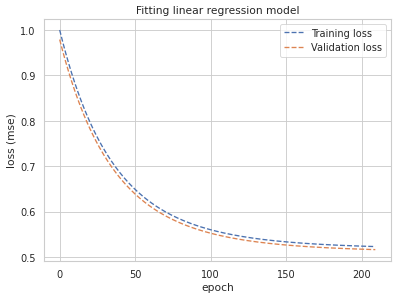

In [19]:
# @hidden
f, ax = plt.subplots()
ax.plot(reg.model.history["loss"], "--", label="Training loss")
ax.plot(reg.model.history["val_loss"], "--", label="Validation loss")
ax.set_title("Fitting linear regression model")
ax.set_xlabel("epoch")
ax.set_ylabel("loss (mse)")
ax.legend();

MAE (78,682) is 35.49% of mean
RMSE (117,887) is 53.18% of mean
MAPE 47.35%
R2 Score is 0.479


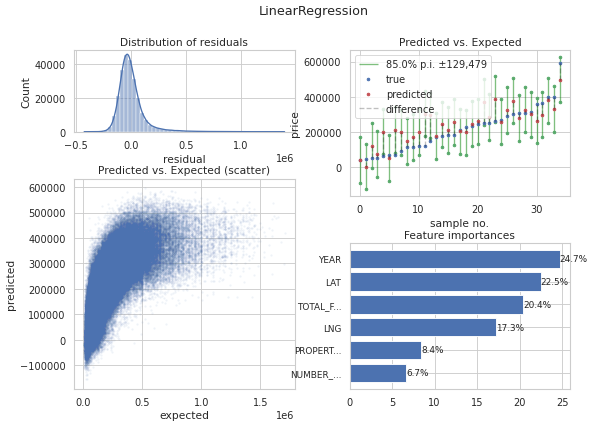

In [20]:
yhat, interval = [y_scaler.inv(y) for y in reg.predict(val_X)]
Result("LinearRegression", yhat, interval, abs(reg.model.weights));

The model performed better than expected, however it still wasn't great. We can begin to see which features have the most importance, such as the total floor area and location data. I will avoid other linear models, as they will likely perform similarly, and will instead try neighbour and tree-based methods instead.

####  K-Nearest Neighbour
I will now try the K-Nearest Neighbour algorithm to test if the distances between points, especially in their coordinates, can significantly impact the outcome price.
The KNN algorithm works by using feature similarity to predict the values of new unseen data. A new point is assigned a value based on how closely it resembles other points in the training set, i.e the distance between them. The distance can be calculated using the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), or other methods such as the [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry), or [Chebyzchev](https://en.wikipedia.org/wiki/Chebyshev_distance), distance. It then sorts the points and aggregrates the closest points for the outcome. This could be majority voting for classification, or the neighbourhood average for regression. The model is very sensitive to the **curse of dimensionality**, where adding more features doesn't benefit the model, rather it adds noise and hinders its performance.

##### Implementation
I will implement a custom model that utilises cuML's nearest neighbour search that will return the prediction as the **inverse distance weighted** average of the nearest neighbours, which will favour closer points.
$$
\bar x = \frac{\sum_{i=1}^n w_i x_i}{\sum_{i=1}^nw_i} \textrm{  where  } w_i = \frac{1}{d_{ix}^p}
$$
To avoid zero division errors, I will only compute the weights of non-zero rows and will fill any remaining rows with a weights of 1 for zero distance, and 0 for all other distances. Since a distance of zero means an output sample is identical to the user's input, setting all other weights to 0 will solely favour the zero-distance sample for the output. To illustrate:
```
distance matrix = 
[[0.1, 0.4, 1.2, 2.1],
 [0.0, 0.2, 1.3, 1.9],
 [0.0, 0.1, 0.2, 0.1],
 [0.5, 0.6, 0.9, 1.1]]
weights(distance matrix) =
[[100, 6.25, 0.69, 0.22],
 [1.0,  0.0,  0.0,  0.0],
 [1.0,  0.0,  0.0,  0.0],
 [4.0, 2.78, 1.23, 0.83]]
```


In [21]:
# algorithms/knn/__init__.py
# algorithms/knn/__init__.py

class KNNRegressor(object):
    def __init__(self, n_neighbours:int=5, idw_power:int=1):
        self.n_neighbours_ = n_neighbours
        self.idw_power_ = idw_power

    def fit(self, X, y, **kwargs):
        self.fit_X_ = X
        self.fit_y_ = y
        self.nearest_neigh_ = NearestNeighbors(**kwargs)
        self.nearest_neigh_.fit(X)
        return self

    def weights_fn(self, dist):
        weights = np.empty_like(dist)
        # masking all non-zero distance samples
        non_zero = np.all(dist!=0, axis=1)
        # setting non-zero weights to 1/dist^p
        weights[non_zero] = 1 / np.power(dist[non_zero], self.idw_power_ )
        # binary mapping zero distance to 1 and 0 for all other.
        weights[~non_zero] = (dist[~non_zero] == 0).astype(float)
        return weights

    def predict(self, X):
        # getting k nearest neighbours
        dist, idx = self.nearest_neigh_.kneighbors(X, self.n_neighbours_)
        return np.average(self.fit_y_[idx], axis=1, weights=self.weights_fn(dist))

##### Fitting and evaluating

In [22]:
fn = "models/KNearestNeigh.bin"
if not os.path.exists(fn):
    reg = KNNRegressor(n_neighbours=5).fit(tr_X[:,1:], tr_y2) # omitting HPI column as not informative for stationary adjusted prices
    dump(reg, fn)
reg = ConformalRegression(load(fn)).calibrate(cal_X[:,1:], cal_y2)

In [23]:
feat_imp = np.array([0.37192433, 0.28135066, 0.17182901, 0.0468285, 0.10096733])
    # permutation_importance(lambda x: reg.predict(x, alpha=None), val_X[:25_000, 1:], val_y[:25_000])

MAE (63,421) is 28.61% of mean
RMSE (103,374) is 46.63% of mean
MAPE 21.28%
R2 Score is 0.767


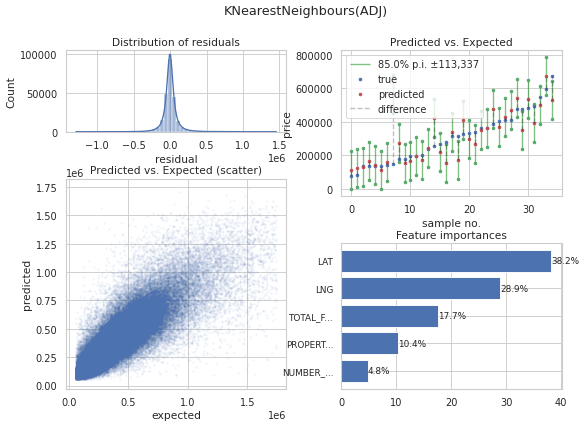

In [24]:
yhat, interval = [y2_scaler.inv(y) * LATEST_INDEX for y in reg.predict(val_X[:,1:])]
Result("KNearestNeighbours(ADJ)", yhat, interval, feat_imp, inv_y2, X.columns[1:]);

#### Decision Tree regression
Now, I will attempt to implement a regression tree. I expect that the model will not perform well on its own, and I will probably need to use an ensemble method for best performance. My implementation will probably also be inefficient and will take a considerable amount of time in training, as I will be using recursion and expensive computations to build the tree. Additionally, I will suffer Python's various bottlenecks and overhead, where better, more established implementations use C++ instead.

##### Implementation

In [25]:
# algorithms/decision_tree/base.py
# algorithms/decision_tree/base.py

class BaseNode(object):
    def predict(self,X:ndarray):
        raise NotImplementedError()
        
def numeric(x, name, *, dtype=(float,int), min=float("-inf"), max=float("inf"), min_closed=True, max_closed=True):
    if not isinstance(x, dtype):
        type_ = dtype.__name__ if hasattr(dtype,"__name__") else [dt.__name__ for dt in dtype]
        raise TypeError(f"'{name}' parameter must be of type {type_}")

    interval = {
        (True,True): lambda x: min <= x <= max, # if closed interval
        (True,False): lambda x: min <= x < max, # if min closed, max open
        (False,True): lambda x: min < x <= max, # if min open, max closed
        (False,False): lambda x: min < x < max, # if open interval
    }
    mibr = "[" if min_closed else "("
    mabr = "]" if max_closed else ")"
    if not interval[(min_closed, max_closed)](x):
        raise ValueError(f"'{name}' parameter must be in interval {mibr}{min},{max}{mabr}")
    return x

AggregateFunction = Callable[[ndarray],float]
CriterionFunction = Callable[[ndarray],ndarray]
ThreshSelectFunction = Callable[[ndarray],ndarray]

In [26]:
# algorithms/decision_tree/node.py
# algorithms/decision_tree/node.py

class DecisionNode(BaseNode):
    def __init__(self,feature_idx,threshold,left,right):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right

class LeafNode(BaseNode):
    def __init__(self,data):
        self.data = data

    def predict(self,X:ndarray):
        # finally reach leaf, so return data
        return self.data

In [27]:
# algorithms/decision_tree/__init__.py
# algorithms/decision_tree/__init__.py

from collections import namedtuple
Node = namedtuple("Node", "feature_idx threshold left right data", defaults=[None]*5)

class DecisionTree(object):
    # ===== aggregation functions =====
    # == regression ==
    @staticmethod
    def mean_aggr(y):
        # aggregating predictions by mean
        return np.mean(y)
    # == classification ==
    @staticmethod
    def majority_aggr(y):
        # returning class with majority prediction
        vals, counts = np.unique(y, return_counts=True)
        return vals[np.argmax(counts)]

    # ===== criterion functions =====
    # == regression ==
    @staticmethod
    def variance(y):
        return np.sum(np.square(y - y.mean())) / len(y)
    # == classification ==
    @staticmethod
    def _calc_proba(y):
        return np.unique(y,return_counts=True)[1] / len(y)
    @staticmethod
    def gini(y):
        proba = DecisionTree._calc_proba(y)
        return 1 - np.sum(np.square(proba))
    @staticmethod
    def entropy(y):
        proba = DecisionTree._calc_proba(y)
        return - np.sum(proba*np.log2(proba))

    # ===== impurity reduction / information gain =====
    def information_gain(self, parent, left, right) -> float:
        # information gain = (parent impurity) - (average children impurity)
        parent_impurity = self.criterion(parent)
        left_impurity = self.criterion(left) * len(left)
        right_impurity = self.criterion(right) * len(right)
        return parent_impurity - (left_impurity+right_impurity)/len(parent)
        
    reg_type = {"reg", "regression", "regressor"}
    cls_type = {"cls", "classification", "classifier"}

    def __init__(self,
                 max_depth:int=5,
                 max_features:float=1.,
                 min_samples_split:int=2,
                 min_samples_leaf:int=1,
                 min_split_gain:float=0,
                 select_thresholds:ThreshSelectFunction="default",
                 aggregate:Union[str,AggregateFunction]="regression",
                 criterion:Union[str,CriterionFunction]="variance",
                 seed=None
                ):
        self.random_state = np.random.RandomState(seed)
        self.root = None

        self.max_depth = numeric(max_depth, "max_depth", dtype=int, min=3)
        self.max_features = numeric(max_features, "max_features", dtype=float, min=0, max=1, min_closed=False)
        self.min_samples_leaf = numeric(min_samples_leaf, "min_samples_leaf", dtype=int, min=1)
        self.min_samples_split = numeric(min_samples_split, "min_samples_split", dtype=int)
        self.min_split_gain = numeric(min_split_gain, "min_split_gain", min=0.)

        # threshold selection function validation
        sel_options = {
            "default": lambda x: x # no special threshold selection
        }
        self.select_thresholds = sel_options.get(select_thresholds, select_thresholds)        
        if not callable(self.select_thresholds):
            raise TypeError(f"'select_thresholds' parameter must be in {set(sel_options.keys())} or 'callable(ndarray) -> ndarray'")

        # aggregate function validation
        aggr_options = {
            **{k:self.mean_aggr for k in self.reg_type}, # mean aggregation for regression
            **{k:self.majority_aggr for k in self.cls_type} # majority aggregation for classification
        }
        self.aggregate = aggr_options.get(aggregate, aggregate)
        if not callable(self.aggregate):
            raise TypeError(f"'aggregate' parameter must be in {self.reg_type | self.cls_type} or 'callable(ndarray) -> float'")
        
        # criterion function validation
        criterion_options = {
            "gini":self.gini,
            "entropy":self.entropy,
            "variance":self.variance,
        }
        self.criterion = criterion_options.get(criterion,criterion)
        if not callable(self.criterion):
            raise TypeError(f"'criterion' parameter must be in {set(criterion_options.keys())} or 'callable(ndarray) -> ndarray'")

    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if n_samples > self.min_samples_leaf and depth <= self.max_depth:
            feature_idx, threshold, left, right, gain = self.get_best_split(X, y, n_samples, n_features) # finding best split
            # splitting if information gain greater than some parameter (default 0)
            if gain > self.min_split_gain: 
                left_subtree = self.build_tree(X[left], y[left], depth + 1)
                right_subtree = self.build_tree(X[right], y[right], depth + 1)
                return Node(feature_idx, threshold, left_subtree, right_subtree)
        # leaf node if max depth reached, minimum samples in leaf, minimum samples in split
        # aggregrating sample points into single point
        leaf_data = self.aggregate(y)
        return Node(data=leaf_data)

    def get_best_split(self, X, y, n_samples, n_features):
        split = None
        idx = np.arange(n_samples)
        best = float("-inf")
        # selecting features randomly
        sel_features = self.random_state.permutation(n_features)[:int(round(n_features*self.max_features))]
        # iterating through features
        for feature_idx in sel_features:
            feature = X[:,feature_idx] # getting current column of dataset
            thresh_potential = self.select_thresholds(np.unique(feature)) # selecting potential thresholds
            # iterating through thresholds to find best feature-threshold combination
            for threshold in thresh_potential:
                left = idx[feature <= threshold] # getting indices of data points less than threshold for left subtree
                right = idx[feature > threshold] # getting indices of data points greater than threshold for right subtree
                # if minimal data after split skip execution and begin next iteration
                if len(left) <= self.min_samples_split or len(right) <= self.min_samples_split:
                    continue
                # calculating quality of split
                gain = self.information_gain(y, y[left], y[right])
                if gain >= best:
                    split = ( feature_idx, threshold, left, right, gain )
                    best = gain
        return split
        
    def fit(self,X,y):
        self.root = self.build_tree(X,y)
        return self
    
    def _predict(self,X,node):
        # if leaf node, return data
        if node.data is not None:
            return node.data

        # recursively traversing down tree
        val = X[node.feature_idx]
        if val <= node.threshold: # traverse left if value of feature in X less than threshold
            return self._predict(X,node.left)
        else: # otherwise traverse right
            return self._predict(X,node.right)
            
    def predict(self,X):
        return np.array([self._predict(x,self.root) for x in X])

##### Fitting and evaluating

In [28]:
def cluster_thresholds(array, diff, aggr=np.mean):
    # aggregrating similar thresholds to reduce number of potential splits
    tmp = array.copy()
    groups = []
    while len(tmp):
        # select seed
        seed = tmp.min()
        mask = (tmp - seed) <= diff
        groups.append(aggr(tmp[mask, None]))
        tmp = tmp[~mask]
    return groups

In [29]:
from functools import partial

fn = "models/DecisionTree.bin"
if not os.path.exists(fn):
    reg = DecisionTree(
        max_depth=7, # stop growing at depth 7
        min_samples_leaf=512, # to speed up training
        aggregate="regression", # mean aggregrate samples at leaf node
        criterion="variance", # use variance reduction
        # cluster and aggregrate thresholds with 0.005 difference between them, categorical features should stay unaffected
        select_thresholds=partial(cluster_thresholds, diff=0.005),
        seed=SEED
    ).fit(tr_X[:,1:], tr_y2)
    dump(reg, fn)
reg = ConformalRegression(load(fn)).calibrate(cal_X[:,1:], cal_y2)

In [30]:
feat_imp = permutation_importance(lambda x: reg.predict(x, alpha=None), val_X[:,1:], val_y2)

MAE (81,266) is 36.66% of mean
RMSE (125,512) is 56.62% of mean
MAPE 28.47%
R2 Score is 0.657


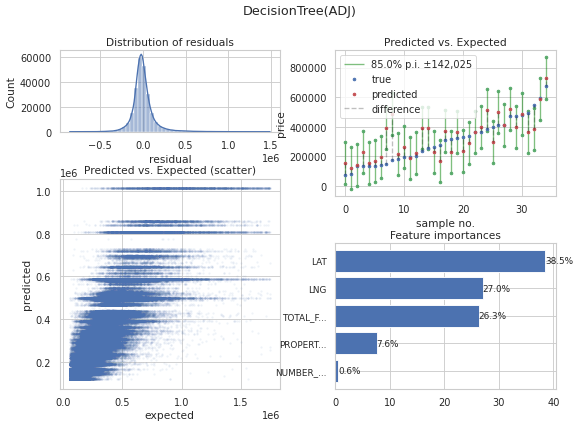

In [31]:
yhat, interval = [y2_scaler.inv(y) * LATEST_INDEX for y in reg.predict(val_X[:,1:])]
Result("DecisionTree(ADJ)", yhat, interval, feat_imp, inv_y2, X.columns[1:]);

As seen above, the model produces discrete predictions based on the leaf nodes of the fitted tree. I believe increasing the maximum depth (thereby increasing the number of leaves) would help improve the bands of predictions that can be seen on the scatter diagram. Despite this issue, I believe using an ensemble method to combine multiple trees will greatly reduce the issues I have described.

#### Random Forest


##### Hyperparameter optimisation
I will begin by optimising the random forest's parameters on a small set of data, with a low number of estimators, for quick and effective computation. The models will be optimised to minimise the RMSE (root mean squared error) of the predictions. I will be running the optimisation over 100 iterations. I will be using the `hyperopt` library which will make this process rapid and reliable.

In [32]:
pbounds = {
    "max_depth": hp.uniformint("max_depth", 5, 20), # maximum depth to grow trees to, too high/low could result in overfitting/underfitting
    "max_features": hp.uniform("max_features", 0.5, 1.0), # maximum number of features to consider when making splits
    "min_samples_split": hp.uniformint("min_samples_split", 1, 64), # minimum number of samples required to split
    "min_samples_leaf": hp.uniformint("min_samples_leaf", 1, 64), # minimum number of samples in each leaf node
    # static parameters
    "n_bins":256,
    "n_estimators": 50, # number of trees to build. low number for now, will increase when fitting resulting model
    "random_state": SEED # for reproducibility, may still have some randomness due to n_streams > 1.
}

n = 100_000
idx = np.random.permutation(len(tr_X))[:n]
sample_x, sample_y = tr_X[idx,1:].astype(np.float32), tr_y2[idx].astype(np.float32)

In [33]:
fn = "models/_rf_trials.hyperopt"
trials = Trials() if not os.path.exists(fn) else load(fn)

result = fmin(
    fn = objective(
        model = RandomForestRegressor,
        X = sample_x,
        y = sample_y,
        cv = 5,
    ),
    space = pbounds,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

if not os.path.exists(fn):
    dump(trials, fn)

rfparams = {k:v[0] for k,v in trials.best_trial["misc"]["vals"].items()}
rfparams["max_depth"] = int(rfparams["max_depth"])
rfparams["min_samples_split"] = int(rfparams["min_samples_split"])
rfparams["min_samples_leaf"] = int(rfparams["min_samples_leaf"])

100%|██████████| 100/100 [00:00<?, ?trial/s, best loss=?]


best loss: 0.2328524947166443,
params: {'max_depth': 20,
 'max_features': 0.9965555438979297,
 'min_samples_leaf': 6,
 'min_samples_split': 7}


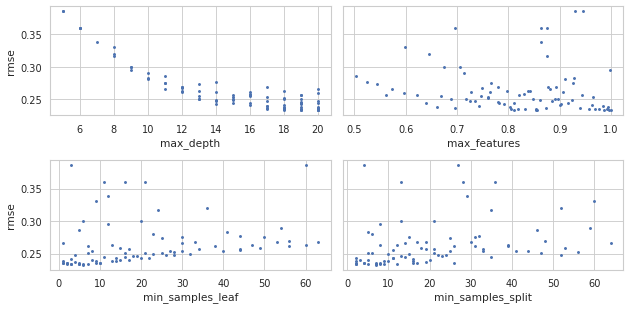

In [34]:
# @hidden
f, axs = plt.subplots(2, (len(trials.vals)+1)//2, sharey=True, figsize=(10,5))
axs[0,0].set_ylabel("rmse")
axs[1,0].set_ylabel("rmse")
for k, ax in zip(trials.vals, axs.flatten()):
    ax.scatter(trials.vals[k], trials.losses(), 5)
    ax.set_xlabel(k)

print(f"""best loss: {trials.best_trial["result"]["loss"]},
params: {pformat(rfparams)}""")

f.tight_layout()

##### Fitting and evaluating

In [35]:
fn = "models/RandomForest.bin"
if not os.path.exists(fn):
    # gpu accelerated training
    rf = RandomForestRegressor(
        **rfparams,
        n_bins = 256,
        n_estimators = 100,
    ).fit(tr_X[:,1:].astype(np.float32), tr_y2.astype(np.float32))
    # serialising as treelite model to make available
    # for cpu inference and cross-platform
    tl_model = rf.convert_to_treelite_model()
    del rf
    tl_model.to_treelite_checkpoint(fn)
else:
    tl_model = treelite.Model.deserialize(fn)
reg = ConformalRegression(ForestInference().load_from_treelite_model(tl_model, output_class=False)).calibrate(cal_X[:,1:], cal_y2)

In [36]:
feat_imp = permutation_importance(lambda x: reg.predict(x, alpha=None), val_X[:,1:], val_y)

MAE (55,801) is 25.17% of mean
RMSE (90,258) is 40.71% of mean
MAPE 19.38%
R2 Score is 0.823


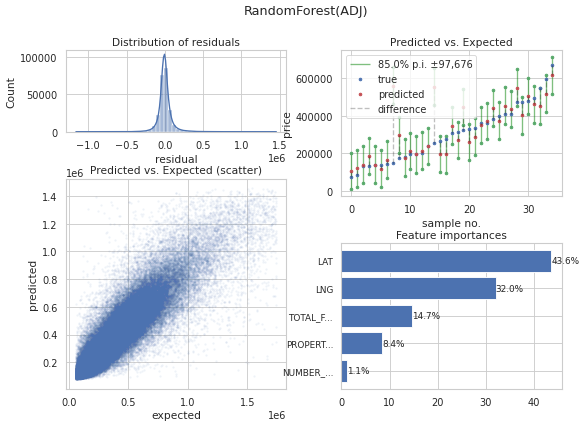

In [37]:
yhat, interval = [y2_scaler.inv(y) * LATEST_INDEX for y in reg.predict(val_X[:,1:])]
Result("RandomForest(ADJ)", yhat, interval, feat_imp, inv_y2, X.columns[1:]);

I am pleased with the performance of the random forest as it is not only versatile, but also extremely fast, as a result of the **treelite** compiler and the gpu-accelerated **ForestInference** front-end. I will now test gradient boosting machines (**XGBoost**) accelerated with treelite and ForestInference, to test if it can also perform with similar efficiency.

#### Gradient Boosting Machine

##### Hyperparameter Optimisation
Similar to the random forest, I will begin by optimising the parameters of the gradient boosting machine using `hyperopt`.

In [38]:
pbounds = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.25),
    "max_depth": hp.uniformint("max_depth", 5, 20), # maximum depth to grow trees to, too high/low could result in overfitting/underfitting
    "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1.0), # maximum number of features to consider when making splits
    "min_child_weight": hp.uniformint("min_child_weight", 1, 32), # minimum number of samples in each leaf node
    # static parameters
    "random_state": SEED,
    "n_estimators": 50,
    "tree_method": "gpu_hist" # gpu acceleration
}

n = 50_000
idx = np.random.permutation(len(tr_X))[:n]
sample_x, sample_y = tr_X[idx, 1:].astype(np.float32), tr_y2[idx].astype(np.float32)

In [39]:
fn = "models/_xgb_trials.hyperopt"
trials = Trials() if not os.path.exists(fn) else load(fn)

result = fmin(
    fn = objective(
        model = xgb.XGBRegressor,
        X = sample_x,
        y = sample_y,
        cv = 2,
    ),
    space = pbounds,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)
if not os.path.exists(fn):
    dump(trials, fn)

xgbparams = {k:v[0] for k,v in trials.best_trial["misc"]["vals"].items()}
xgbparams["max_depth"] = int(round(xgbparams["max_depth"]))
xgbparams["min_child_weight"] = int(round(xgbparams["min_child_weight"]))

100%|██████████| 100/100 [00:00<?, ?trial/s, best loss=?]


best loss: 0.22684506326913834,
params: {'colsample_bynode': 0.8708868938454073,
 'learning_rate': 0.2088532944217484,
 'max_depth': 11,
 'min_child_weight': 17}


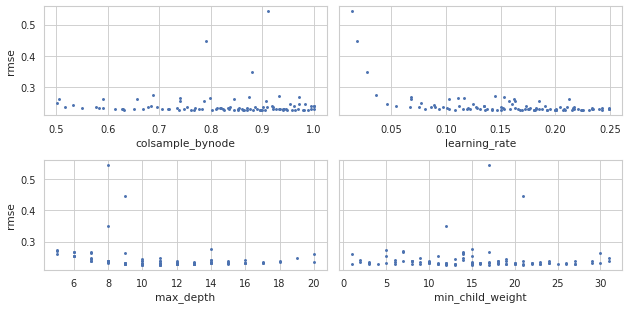

In [40]:
# @hidden
f, axs = plt.subplots(2, (len(trials.vals)+1)//2, sharey=True, figsize=(10,5))
axs[0,0].set_ylabel("rmse")
axs[1,0].set_ylabel("rmse")
for k, ax in zip(trials.vals, axs.flatten()):
    ax.scatter(trials.vals[k], trials.losses(), 5)
    ax.set_xlabel(k)

print(f"""best loss: {trials.best_trial["result"]["loss"]},
params: {pformat(xgbparams)}""")

f.tight_layout()

##### Fitting and evaluating

In [41]:
fn = "models/XGBoost.bin"
if not os.path.exists(fn):
    dtrain = xgb.DMatrix(tr_X[:,1:], tr_y2)
    dtest = xgb.DMatrix(val_X[:,1:], val_y2)
    xgbparams["random_state"] = SEED
    xgbparams["tree_method"] = "gpu_hist"
    xgb_ = xgb.train(xgbparams, dtrain, evals=[(dtrain, "train"), (dtest, "val")], num_boost_round=2000, early_stopping_rounds=10)
    xgb_.save_model(fn)
else:
    xgb_ = xgb.Booster()
    xgb_.load_model(fn)
reg = ConformalRegression(ForestInference().load(fn, output_class=False)).calibrate(cal_X[:,1:], cal_y2)

[0]	train-rmse:0.94074	val-rmse:0.94086
[1]	train-rmse:0.80932	val-rmse:0.80955
[2]	train-rmse:0.71279	val-rmse:0.71322
[3]	train-rmse:0.64249	val-rmse:0.64307
[4]	train-rmse:0.59205	val-rmse:0.59300
[5]	train-rmse:0.55624	val-rmse:0.55738
[6]	train-rmse:0.53050	val-rmse:0.53204
[7]	train-rmse:0.51153	val-rmse:0.51330
[8]	train-rmse:0.49585	val-rmse:0.49798
[9]	train-rmse:0.48542	val-rmse:0.48783
[10]	train-rmse:0.47730	val-rmse:0.48009
[11]	train-rmse:0.47099	val-rmse:0.47413
[12]	train-rmse:0.46541	val-rmse:0.46888
[13]	train-rmse:0.46154	val-rmse:0.46531
[14]	train-rmse:0.45853	val-rmse:0.46251
[15]	train-rmse:0.45556	val-rmse:0.45971
[16]	train-rmse:0.45246	val-rmse:0.45687
[17]	train-rmse:0.45079	val-rmse:0.45544
[18]	train-rmse:0.44841	val-rmse:0.45332
[19]	train-rmse:0.44641	val-rmse:0.45162
[20]	train-rmse:0.44471	val-rmse:0.45016
[21]	train-rmse:0.44286	val-rmse:0.44845
[22]	train-rmse:0.44200	val-rmse:0.44776
[23]	train-rmse:0.44039	val-rmse:0.44633
[24]	train-rmse:0.43977	va

MAE (54,270) is 24.48% of mean
RMSE (87,746) is 39.58% of mean
MAPE 18.80%
R2 Score is 0.832


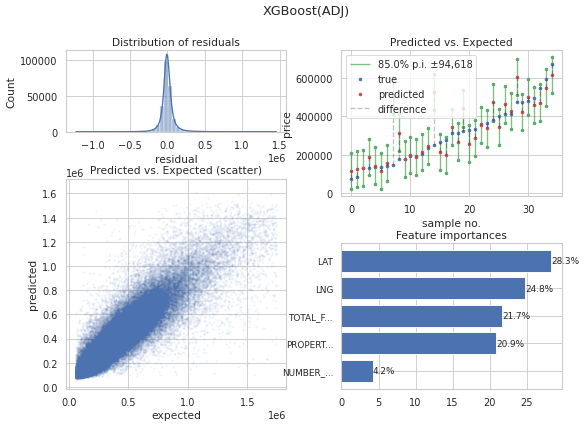

In [42]:
yhat, interval = [y2_scaler.inv(y) * LATEST_INDEX for y in reg.predict(val_X[:,1:])]
Result("XGBoost(ADJ)", yhat, interval, xgb_.get_score(importance_type='gain').values(), inv_y2, X.columns[1:]);

#### Multilayer Perceptron

##### Implementation
I will be implementing the multilayer perceptron through a modular layer-based implementation.

###### Layers
Each layer type will be implemented with a `forward` and `backward` methods. The `forward` method will feed input through the network, applying the current layer's function on the previous' output. And the `backward` method will propagate the loss back through the network, updating trainable parameters along the way.
I will only be implementing 2 layer types, the perceptron layer, with trainable weights, and the leaky ReLU non-linear activation function.

I will use Xavier or He initialisation for the weights:
$$
\text{Xavier}: W \sim N\left(0, \frac 2{n_{in} + n_{out}}\right)\\
\text{He}: W \sim N\left(0, \frac 2{n_{in}}\right)
$$
Where,  
$N(\mu, \sigma^2)$: normal distribution with mean $\mu$ and variance $\sigma^2$  
Since I will be using the leaky ReLU activation, I will likely use He initialisation.

The leaky ReLU activation function can be expressed as:
$$
\sigma(x) = \begin{cases}
    x&\quad x \ge 0\\
    cx&\quad x < 0\\
\end{cases}
\\
\sigma'(x) = \begin{cases}
    1&\quad x > 0\\
    c&\quad x < 0\\
    DNE&\quad x = 0
\end{cases}
$$
Where,  
$c$: constant parameter, typically $0 < c < 1$  
While the leaky ReLU function is non-differentiable at $x = 0$, it is relatively rare in the context of deep learning and can thus be set arbitrarily, typically to c or 1.

In [43]:
# algorithms/mlp/base.py
# algorithms/mlp/base.py

NDArrayFunction = Callable[[ndarray], ndarray]
LossFunction = Callable[[ndarray, ndarray], ndarray]
WeightsInitFunction = Callable[[int, int], ndarray]

class BaseOptimiser(object):
    def __init__(self):
        # self.reset()
        pass

    def reset(self):
        raise NotImplementedError()
    
    def update(self, grad:ndarray, id:str) -> ndarray:
        raise NotImplementedError()

class BaseLayer(object):
    def __init__(self, id:str=None):
        self.id = id
        # self.reset()
    
    def reset(self):
        self.inp = None

    def forward(self, inp:ndarray) -> ndarray:
        raise NotImplementedError()

    def backward(self, grad:ndarray, optimiser:BaseOptimiser) -> ndarray:
        raise NotImplementedError()

class ActivationLayer(BaseLayer):
    def __init__(self, fn:NDArrayFunction, prime:NDArrayFunction, id:str=None):
        super().__init__(id)
        self.fn = fn
        self.prime = prime
    
    def forward(self, inp):
        self.inp = inp # storing x for back propagation
        return self.fn(inp)

    def backward(self, grad, optimiser): # optimiser parameter for consistency, will not be used
        return self.prime(self.inp) * grad # hadamard product - applying chain rule

In [44]:
# algorithms/mlp/layers.py
# algorithms/mlp/layers.py

class PerceptronLayer(BaseLayer):
    @staticmethod
    def xavier_init(n_in, n_out, seed=None):
        np.random.seed(seed)
        return np.random.normal(
            loc = 0.0,
            scale = np.sqrt(2/(n_in + n_out)),
            size = (n_in, n_out),
        )
        
    @staticmethod
    def he_init(n_in, n_out, seed=None):
        np.random.seed(seed)
        return np.random.normal(
            loc = 0.0,
            scale = np.sqrt(2/n_in),
            size = (n_in, n_out),
        )

    def __init__(self, n_in:int, n_out:int, weights_init:Union[str,WeightsInitFunction]="he", add_bias=True, id:str=None, seed=None):
        super().__init__(id)
        self.seed = seed
        self.n_in = n_in
        self.n_out = n_out
        self.add_bias = add_bias
        options = {
            "he":self.he_init,
            "kaiming":self.he_init,
            "xavier":self.xavier_init,
            "glorot":self.xavier_init,
        }
        self.weights_init = options.get(weights_init,weights_init)
        if not callable(self.weights_init):
            raise ValueError(f"`weights_init` must be a string in {set(options.keys())} or callable(n_in, n_out, seed):ndarray[n_in, n_out]")
        self.reset()
    
    def reset(self):
        super().reset()
        # initialise weights
        self.weights = self.weights_init(self.n_in, self.n_out, self.seed)
        self.bias = np.zeros((1,self.n_out))
        
    def forward(self, inp):
        self.inp = inp # storing input for back propagation
        return np.dot(self.inp, self.weights) + self.bias # y = w.x + b
        
    def backward(self, grad, optimiser):
        grad_inp = np.dot(grad, self.weights.T) # gradient of loss wrt input for backpropagation
        
        grad_weights = np.dot(self.inp.T, grad) # gradient of loss wrt weights
        grad_bias = np.mean(grad, axis=0) # gradient of loss wrt bias 

        self.weights -= optimiser.update(grad_weights, self.id+"weights")
        if self.add_bias:
            self.bias -= optimiser.update(grad_bias, self.id+"bias")
        return grad_inp


class LeakyReLU(ActivationLayer):
    def __init__(self, alpha:float, id:str=None):
        self.alpha = alpha
        super().__init__(self.fn, self.prime, id)

    def fn(self, inp):
        # x >= 0: x
        #  x < 0: x * alpha
        return np.maximum(inp, self.alpha*inp)

    def prime(self, inp):
        # x >= 0: 1
        #  x < 0: alpha
        return np.where(inp < 0, self.alpha, np.ones_like(inp))

###### Parameter optimisation
I will be optimising trainable parameters using Adam (Adaptive Moment Estimation) optimisation which utilises momentum to make the gradient descent algorithm converge towards the minima faster.

$$
m := \beta_1 m + (1 - \beta_1)g\\
v := \beta_2 v + (1 - \beta_2)g^2
$$
$m$ and $v$ are the first (mean) and second (uncentered variance) moment estimates of the gradient $g$. As $m$ and $v$ are initialised as 0, they are biased towards zero, especially during the initial time steps and when the decay rates are small. Therefore, to counteract these biases, we need to compute bias-corrected first and second moment estimates:
$$
\hat m = \frac{m}{1-(\beta_1)^t}\quad\quad\hat v = \frac{v}{1-(\beta_2)^t}
$$
Finally we can update parameter $\phi$:
$$
\phi := \phi - \frac{\eta}{\sqrt{\hat v_t}+\epsilon}\hat m_t
$$
Where,  
$\phi$: Objective parameter  
$g$: Gradient of some cost function w.r.t to the objective parameter  
$m$: first moment (mean) estimate - initialised at 0  
$v$: second moment (variance) estimate - initialised at 0  
$t$: time step - intialised at 1, incremented after each iteration  
$\eta$: initial learning rate  
$\beta_1$: first moment estimate coefficient - default 0.9  
$\beta_2$: second moment estimate coefficient - default 0.999  
$\epsilon$: term to avoid zero division - default $10^{-8}$  

In [45]:
# algorithms/mlp/optimisers.py
# algorithms/mlp/optimisers.py

class AdamOptimiser(BaseOptimiser):
    def __init__(self, lr:float=0.01, beta1:float=0.9, beta2:float=0.999, eps:float=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.reset()

    def reset(self):
        self.cache_m = dict()
        self.cache_v = dict()
        self.cache_t = dict()

    def update(self, grad, id):
        # retrieve previous iteration variables
        m = self.cache_m.get(id, 0)
        v = self.cache_v.get(id, 0)
        t = self.cache_t.get(id, 1)
        # update variables for current iteration
        self.cache_m[id] = self.beta1 * m + (1 - self.beta1) * grad
        self.cache_v[id] = self.beta2 * v + (1 - self.beta2) * grad ** 2
        # bias-corrected variable
        m_corrected = self.cache_m[id] / (1 - self.beta1 ** t)
        v_corrected = self.cache_v[id] / (1 - self.beta2 ** t)
        self.cache_t[id] = t + 1
        # delta calculation
        delta = self.lr * m_corrected / (np.sqrt(v_corrected) + self.eps)
        return delta

###### Neural network

In [46]:
# algorithms/mlp/model.py
# algorithms/mlp/model.py

from sklearn.base import BaseEstimator

def mse(y, yhat):
    return np.mean(np.power(y-yhat, 2))

def mse_prime(y, yhat):
    return 2*(yhat-y)/y.size
    
class NeuralNetwork(BaseEstimator):
    def __init__(self, layers:list[BaseLayer], optimiser:BaseOptimiser, loss_fn:LossFunction=mse, loss_prime:LossFunction=mse_prime):
        self.layers = layers
        self.loss_fn = loss_fn
        self.loss_prime = loss_prime
        self.optimiser = optimiser

    def reset(self):
        # resetting model components
        self.history = dict()
        self.optimiser.reset()
        for l in self.layers: l.reset()

    def predict(self,X:ndarray) -> ndarray:
        out = np.asarray(X)
        # forward propagation
        for l in self.layers:
            out = l.forward(out)
        # clearing cached layer inputs
        for layer in self.layers:
            layer.inp = None
        return out

    def backpropagate(self, X:ndarray, y:ndarray) -> float:
        out = self.predict(X)
        grad_out = self.loss_prime(y,out)
        for l in self.layers[::-1]: # propagate gradient backwards through network
            grad_out = l.backward(grad_out,self.optimiser)
        return self.loss_fn(y,out)

    @staticmethod
    def batches(X:ndarray, y:ndarray, batch_size:int, shuffle:bool) -> tuple[ndarray, ndarray]:
        n = len(X)
        # random indices if shuffling enabled
        idx = np.random.permutation(n) if shuffle else np.arange(n)
        for i in range(0,n,batch_size):
            batch = idx[i:i+batch_size] # taking indices from index list
            yield X[batch], y[batch] # lazy evaluation

    def fit(self,
            X:ndarray,
            y:ndarray,
            val_X:ndarray = None,
            val_y:ndarray = None,
            epochs:int = 1000,
            batch_size:int = 1,
            early_stopping:int = 20,
            delta:float = 0.01,
            shuffle:bool = False,
            verbose:bool = True
        ):

        for i, l in enumerate(self.layers):
            if l.id is None:
                l.id = f"layer{i}"

        # X,y argument validation
        X, y = np.asarray(X), np.asarray(y)
        if X.ndim == 1 or y.ndim == 1:
            raise ValueError("`X` and `y` arrays must be 2 dimensional")

        self.history = {"loss":[]} # initialising training loss history
        # val_X,val_y argument validation
        if val_X is not None and val_y is not None:
            val_X, val_y = np.asarray(val_X), np.asarray(val_y)
            if val_X.ndim == 1 or val_y.ndim == 1:
                raise ValueError("`val_X` and `val_y` arrays must be 2 dimensional")
            self.history["val_loss"] = [] # initialising validation loss history

        patience = None
        # early_stopping argument validation
        if isinstance(early_stopping, int) and early_stopping > 0:
            patience = early_stopping
            best_loss = np.inf # intialising best loss for model improvement calculation
        else:
            warnings.warn(f"`early_stopping` must be positive non-zero integer not `{early_stopping}`, defaulting to None")


        for i in (pbar:=tqdm(range(epochs), disable=not verbose)):
            # end training if not improved
            if patience is not None and patience <= 0:
                pbar.close()
                if verbose:
                    print(f"Early stopping at epoch {i}")
                break

            epoch_loss = 0
            # split training set into batches for less intensive computation
            for Xb, yb in self.batches(X,y,batch_size,shuffle):
                epoch_loss += self.backpropagate(Xb,yb) * len(Xb) # back propagating model and summing error for batches
            epoch_loss /= len(X) # taking mean error across all batches
            self.history["loss"].append(epoch_loss)

            # testing model on validation set if provided
            if "val_loss" in self.history:
                self.history["val_loss"].append(self.loss_fn(self.predict(val_X), val_y))
            
            # logging epoch info if enabled
            if verbose:
                msg = {"loss": self.history["loss"][-1]}
                if "val_loss" in self.history:
                    msg["val_loss"] = self.history["val_loss"][-1]
                if patience is not None:
                    msg["patience"] = patience
                pbar.set_postfix(msg)
                
            # skip to next iteration if early stopping is disabled
            if patience is None:
                continue

            # if model has improved greater than minimum delta
            if best_loss - epoch_loss >= delta:
                patience = early_stopping # reset patience
                best_loss = epoch_loss 
                continue # skip to next iteration
            patience -= 1 # decrement patience (code wont be reached if model improved)
            
        # clearing cached layer inputs
        for layer in self.layers:
            layer.inp = None

        return self

##### Hyperparameter Optimisation

In [47]:
from algorithms.mlp.layers import PerceptronLayer, LeakyReLU
from algorithms.mlp.optimisers import AdamOptimiser
from algorithms.mlp.model import NeuralNetwork

def build_mlp(hidden_layers, n_units, lrelu_alpha):
    layers = [
        PerceptronLayer(len(X.columns), n_units, seed=SEED),
        LeakyReLU(lrelu_alpha)
    ]
    for i in range(hidden_layers-1):
        layers += [
            PerceptronLayer(n_units, n_units, seed=SEED),
            LeakyReLU(lrelu_alpha)
        ]
    layers.append(PerceptronLayer(n_units, 1, add_bias=False))
    return NeuralNetwork(layers, AdamOptimiser())

In [48]:
pbounds = {
    "hidden_layers": hp.uniformint("hidden_layers", 1, 4),
    "n_units": hp.uniformint("n_units", 24, 56),
    "lrelu_alpha": hp.uniform("lrelu_alpha", 0, 0.5),
}

n = 100_000
idx = np.random.permutation(len(tr_X))[:n]
sample_x, sample_y = tr_X[idx].astype(np.float32), tr_y[idx].astype(np.float32)

In [49]:
fn = "models/_mlp_trials.hyperopt"
trials = Trials() if not os.path.exists(fn) else load(fn)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = fmin(
        fn = objective(
            model = build_mlp,
            X = sample_x,
            y = sample_y.reshape(-1,1),
            cv = 5,
            fit_params = {
                "early_stopping": 5, # speed up training
                "batch_size": 1024,
                "verbose": False,
            }
        ),
        space = pbounds,
        algo = tpe.suggest,
        max_evals = 100,
        trials = trials
    )
if not os.path.exists(fn):
    dump(trials, fn)

nnparams = {k:v[0] for k,v in trials.best_trial["misc"]["vals"].items()}
nnparams["hidden_layers"] = int(round(nnparams["hidden_layers"]))
nnparams["n_units"] = int(round(nnparams["n_units"]))

100%|██████████| 100/100 [10:48<00:00,  6.49s/trial, best loss: 0.25280905636164314]


best loss: 0.25280905636164314,
params: {'hidden_layers': 2, 'lrelu_alpha': 0.04031941259789426, 'n_units': 35}


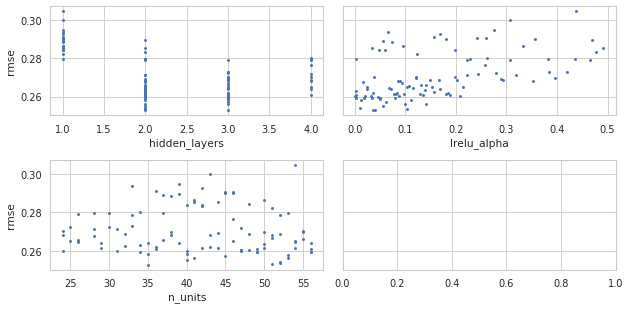

In [50]:
# @hidden
f, axs = plt.subplots(2, (len(trials.vals)+1)//2, sharey=True, figsize=(10,5))
axs[0,0].set_ylabel("rmse")
axs[1,0].set_ylabel("rmse")
for k, ax in zip(trials.vals, axs.flatten()):
    ax.scatter(trials.vals[k], trials.losses(), 5)
    ax.set_xlabel(k)

print(f"""best loss: {trials.best_trial["result"]["loss"]},
params: {pformat(nnparams)}""")

f.tight_layout()

##### Fitting and evaluating

In [51]:
fn = "models/MultilayerPerceptron.bin"
if not os.path.exists(fn):
    nnparams["hidden_layers"] = 3 # 3-5 layers were around the same
    reg = build_mlp(**nnparams).fit(
        tr_X,
        tr_y.reshape(-1,1),
        val_X = val_X,
        val_y = val_y.reshape(-1,1),
        epochs = 1000,
        batch_size = 1024,
        early_stopping = 25,
        delta=0.005,
    )
    dump(reg, fn)
reg = ConformalRegression(load(fn)).calibrate(cal_X, cal_y.reshape(-1,1))

  7%|▋         | 72/1000 [13:15<2:50:51, 11.05s/it, loss=0.161, val_loss=0.161, patience=1] 


Early stopping at epoch 72


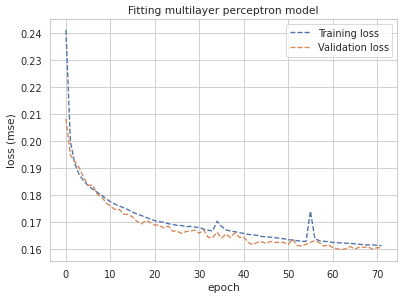

In [52]:
# @hidden
f, ax = plt.subplots()
ax.plot(reg.model.history["loss"], "--", label="Training loss")
ax.plot(reg.model.history["val_loss"], "--", label="Validation loss")
ax.set_title("Fitting multilayer perceptron model")
ax.set_xlabel("epoch")
ax.set_ylabel("loss (mse)")
ax.legend();

In [53]:
feat_imp = permutation_importance(lambda x: reg.predict(x, alpha=None), val_X[:100_000], val_y[:100_000].reshape(-1,1))

MAE (41,696) is 18.81% of mean
RMSE (65,708) is 29.64% of mean
MAPE 23.26%
R2 Score is 0.838


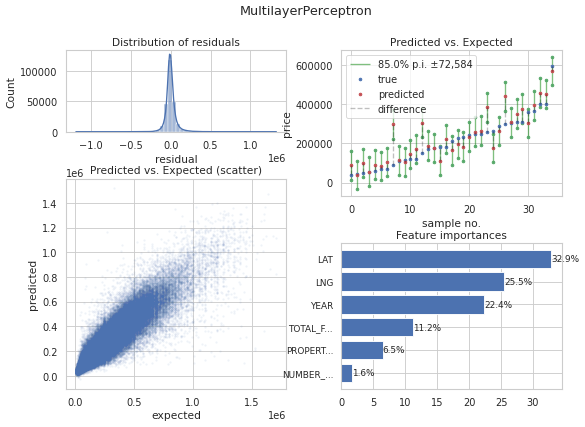

In [54]:
yhat, interval = [y_scaler.inv(y) for y in reg.predict(val_X)]
yhat = yhat.reshape(-1)
Result("MultilayerPerceptron", yhat, interval, feat_imp);

### Conclusion

,r2,mape
LinearRegression,0.479313,47.352439
KNearestNeighbours(ADJ),0.767500,21.275510
DecisionTree(ADJ),0.657260,28.470305
RandomForest(ADJ),0.822758,19.384993
XGBoost(ADJ),0.832487,18.801916
MultilayerPerceptron,0.838236,23.260539


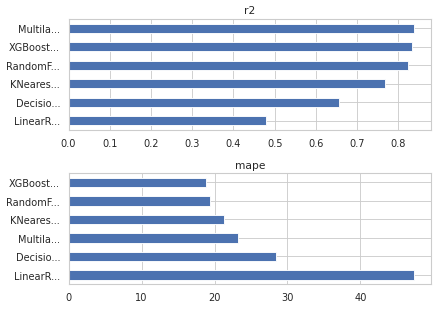

In [55]:
# @hidden
from IPython.display import display
plot = pd.DataFrame(results).T[["r2","mape"]]

display(plot)

f,axs = plt.subplots(2)
asc = {
    "mape":False,
    "r2":True,
}
plot = plot.rename(index=lambda x: x if len(x) <= 10 else x[:7]+"...")
for col,ax in zip(plot, axs.flatten()):
    ax.set_title(col)
    plot[col].sort_values(ascending=asc[col]).plot(kind="barh", ax=ax)
f.tight_layout()

In [56]:
SOURCE = "models/MultilayerPerceptron.bin"
DESTINATION = os.path.join(SERVER_DIR, "model.bin")
os.system(f"cp {SOURCE} {DESTINATION}");

Since I want to use conformal prediction, I will also pre-calibrate and export the calibration scores to the server directory.
By calibrating beforehand, I will not need to calibrate the model in the server, avoiding any intensive computation on the Heroku server-side, which could use resources not available to free users.

In [57]:
calibrated = ConformalRegression(load(SOURCE)).calibrate(cal_X, cal_y.reshape(-1,1))
dump(calibrated.resid_, os.path.join(SERVER_DIR, "conf_resid.bin"));